In [1]:
"""
HiGH DIMENSIONAL ANALYSIS
PROGRAMMING EXERCISE: 02
Name: Nguyen Duc Vu Duy
Student code: 18110004
"""

'\nHiGH DIMENSIONAL ANALYSIS\nPROGRAMMING EXERCISE: 02\nName: Nguyen Duc Vu Duy\nStudent code: 18110004\n'

In [2]:
#Import libraries
import numpy as np
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
!pip install category_encoders #install category_encoders for Ordinal Encoders
import category_encoders as ce
from sklearn.decomposition import PCA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Import dataset
path='https://raw.githubusercontent.com/duynguyenhcmus/Repository/main/HocKy_2/XuLiDaChieu/iris.data'
df=pd.read_csv(path,header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#Transformation label into numeric values
encoder = ce.OrdinalEncoder()
df = encoder.fit_transform(df)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [5]:
#Split the dataset to features and labels
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
print('The shape of features: ',X.shape)

The shape of features:  (150, 4)


Within - class scatter matrix có công thức tính như sau:
\begin{equation*}
S_W=\sum_{i=1}^{C}(x-\mu_i)(x-\mu_i)^T
\end{equation*}
Between - class scatter matrix có công thức tính như sau:
\begin{equation*}
S_B=\sum_{i=1}^{C}N_i(\mu_i-\mu)(\mu_i-\mu)^T
\end{equation*}
Sau khi tính được $S_B, S_W$, ta sẽ tìm các trị riêng, véctơ riêng của $S_W^{-1}S_B$
Ta sẽ chọn các véctơ riêng có trị riêng lớn nhất, xếp thành cột để tạo thành ma trận chuyển đổi W.
\begin{equation*}
X'=XW
\end{equation*}

In [6]:
#Class Linear Discriminant Analysis
class LinearDiscriminantAnalysis:
  def __init__(self,X=X,y=y):
    self.X=X
    self.y=y
    self.mean_vecs=[]
    self.S_W= np.zeros((self.X.shape[1], self.X.shape[1]))
    self.S_B=np.zeros((self.X.shape[1],self.X.shape[1]))
    self.eigen_value=np.array(())
    self.eigen_vec=np.array(())
    self.W=np.ones((self.X.shape[1],2))
  
  #Do Standard Scaler with adjusted variance
  def preprocessing(self):
    #Adjusted Variance
    self.X = (self.X - self.X.mean(axis = 0))/self.X.std(axis = 0, ddof = 1)
  
  #Calculate mean vectors
  def calculate_mean_feature(self):
    for label in range(1, np.unique(self.y).shape[0]):
        self.mean_vecs.append(np.mean(self.X[self.y == label], axis=0))
  
  #Within-class scatter matrix
  def build_SW(self):
    for label, mv in zip(range(1, np.unique(self.y).shape[0]), self.mean_vecs):
        class_scatter = np.cov(self.X[self.y == label].T)
        self.S_W += class_scatter
  
  #Between-class scatter matrix
  def build_SB(self):
    mean_overall = np.mean(self.X, axis=0)
    for i, mean_vec in enumerate(self.mean_vecs):
        n = self.X[self.y == i + 1, :].shape[0]
        mean_vec = mean_vec.reshape(self.X.shape[1], 1)  
        mean_overall = mean_overall.reshape(self.X.shape[1], 1)
        self.S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
  
  #Calculate eigenvalues and eigenvectors of inv(S_W)S_B
  def calculate_eigen(self):
    self.eigen_value,self.eigen_vec=np.linalg.eig(np.linalg.inv(self.S_W).dot(self.S_B))
  
  #Build Transformation matrix by 2 eigenvectors corresponding to 2 largest eigenvalues
  def build_W(self):
    #Build eigenvalues and eigenvector as a pair
    eigen_pairs = [(np.abs(self.eigen_value[i]), self.eigen_vec[:, i])
               for i in range(len(self.eigen_value))]

    #Sort the eigenvalues in ascending order
    eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
    #Stack 2 eigenvalues as columns to construct the transformation matrix
    self.W =self.W* np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
    
    #Transform data by transformation matrix W
  def transform(self):
    return self.X.dot(self.W)
  
  #Step by step LDA
  def full_model(self):
    self.preprocessing()
    self.calculate_mean_feature()
    self.build_SW()
    self.build_SB()
    self.calculate_eigen()
    self.build_W()
    return self.transform()





In [7]:
#Fit model
model=LinearDiscriminantAnalysis()
X_lda= model.full_model()

In [8]:
#Print the eigenvalues of LDA model
model.eigen_value

array([ 1.80406623e+03,  1.64529002e+01, -1.52693195e-13,  1.67963988e-13])

Ta có thể thấy là 2 trị riêng ban đầu lớn hơn rất nhiều so với 2 trị riêng còn lại. Nên ta sẽ lấy 2 véctơ làm ma trận chuyển đổi. Vừa để plot kết quả và 2 véctơ riêng ban đầu cũng capture gần như hoàn toàn thông tin của bộ dữ liệu Iris.

In [9]:
#Transform into dataframe with labels for plot
X_lda_df=pd.DataFrame(np.concatenate((X_lda,y.reshape(-1,1)),axis=1))
X_lda_df

,0,1,2
0,-1.957871,0.029172,1.0
1,-1.752503,0.144931,1.0
2,-1.860733,0.062550,1.0
3,-1.728683,0.158822,1.0
4,-1.990180,0.006239,1.0
...,...,...,...
145,1.482160,-0.556812,3.0
146,1.290894,-0.116351,3.0
147,1.253230,-0.258437,3.0
148,1.446401,-0.575364,3.0


In [10]:
#Fit PCA model for comparison
pca=PCA(n_components=2,random_state=0)
pca.fit(X)
x_pca=pca.transform(X)
X_pca_df=pd.DataFrame(np.concatenate((x_pca,y.reshape(-1,1)),axis=1))
X_pca_df

,0,1,2
0,-2.684207,0.326607,1.0
1,-2.715391,-0.169557,1.0
2,-2.889820,-0.137346,1.0
3,-2.746437,-0.311124,1.0
4,-2.728593,0.333925,1.0
...,...,...,...
145,1.944017,0.187415,3.0
146,1.525664,-0.375021,3.0
147,1.764046,0.078519,3.0
148,1.901629,0.115877,3.0


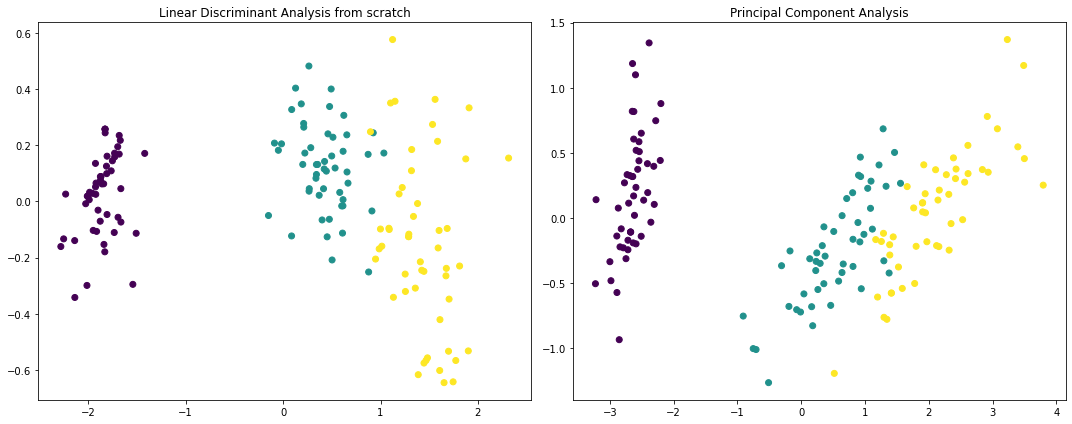

In [11]:
#Plot LDA and PCA model
f, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].scatter(x=X_lda_df.iloc[:,0],y=X_lda_df.iloc[:,1],c=X_lda_df.iloc[:,2])
axs[0].set_title('Linear Discriminant Analysis from scratch')

axs[1].scatter(x=X_pca_df.iloc[:,0],y=X_pca_df.iloc[:,1],c=X_pca_df.iloc[:,2])
axs[1].set_title('Principal Component Analysis')
plt.tight_layout()

Chạy PCA và LDA với 2 thành phần chính tương ứng với 2 véctơ riêng có trị riêng lớn nhất, ta thấy kết quả chạy của 2 thuật toán không có nhiều điểm khác biệt. Cả 2 class cụ thể là versicolor và virginica đều không quá tách biệt quá xa giữa 2 class này, trong khi đó class setosa nằm hoàn toàn ở bên trái hình vẽ, tách biệt với 2 class còn lại. Điều này có thể là do bản thân bộ dữ liệu không có nhiều tách biệt ở 2 class versicolor và virginica.